# Chapter 8 - Using Hybrid Algorithms
1. Monte Carlo method on a QC

© 2021, 2022 Packt Publishing

Written by Alex Khan

In [1]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [3]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [4]:
import numpy as np

In [5]:
# to check all gate operations refer to 
# https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

In [6]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [7]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [8]:
### Please run available_devices() and correct any device names below

def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Advantage_system6.1','Advantage_system4.1','DW_2000Q_6','Aspen-M-1','Aspen-11','IonQ Device']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())

In [9]:
# This function was modified with a return of num_shots
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)
    return(num_shots)

In [10]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

In [11]:
# this function has been updated from the function in past chapters
def run_circuit(circuit, local=True, device_name='', s3_folder='', display_binary=False):
    import matplotlib.pyplot as plt
    %matplotlib inline
    if local==True:
        device = LocalSimulator()
        result = device.run(circuit, shots=1000).result()
    else:
        measured_qubits=len(circuit.qubits)
        device=set_device(device_name)
        num_reads=estimate_cost_measured_qubits(device,measured_qubits)
        print('device', device)
        print('num reads', num_reads)
        result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder).result()
        actual_simulator_cost(device, result)
    counts = result.measurement_counts
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.xlabel('states');
        plt.ylabel('counts');
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(i)
        for i in range(len(x_val)):
            dec_counts[x_val[i]]=y_val[i]
        print(dec_counts)
        plt.bar(x_val, y_val)

        plt.xlabel('states');
        plt.ylabel('counts');
    
    return(result)

In [12]:
def draw_bloch(q, info=True):
    #©2021-2 Alex Khan
    
    import matplotlib.pyplot as plt
    import numpy as np

    if q.shape != (2,1):
        print('Matrix must be only for one qubit')
        print('Shape needed (2,1). Shape given ',q.shape)
        return
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("auto")
    if info==True:
        print('Matrix:')
        print(q)
    # draw Bloch Sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="y", alpha=0.2)

    u = np.linspace(0, 2* np.pi, 100)

    ax.plot(np.sin(u),np.cos(u),0*(u),color='y')
    ax.plot(0*(u),np.sin(u),np.cos(u),color='y')
    ax.plot(np.sin(u),0*(u),np.cos(u),color='y')

    # draw axes
    ax.plot([0,0],[1,-1],[0,0], color='y', linestyle='dotted')
    ax.plot([1,-1],[0,0],[0,0], color='y', linestyle='dotted')
    ax.plot([0,0],[0,0],[1,-1], color='y', linestyle='dotted')

    # draw state labels
    ax.annotate("|0>", xy=(0.0, 0.04), xytext=(0.0, 0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|1>", xy=(0.0, -0.04), xytext=(0.0, -0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|+>", xy=(-0.025, -0.022), xytext=(-0.06, -0.04), arrowprops=dict(arrowstyle="->"), color='y')

    # calculate vector
    
    r0=((q[0].real)**2+(q[0].imag)**2)**0.5
    #print('r0=',r0)
    if r0==0:
        phi0=0
    else:
    
        phi0=np.arccos(q[0].real/r0)
    
    r1=((q[1].real)**2+(q[1].imag)**2)**0.5
    #print('r1=',r1)
    if r1==0:
        phi1=0
    else:
    
        phi1=np.arccos(q[1].real/r1)
    r=(r0**2+r1**2)**0.5
    
    if(r<0.999 or r>1.0001):
        print('vector is  not normalized.  Cannot draw')
        return
    
    if np.sin(q[1].imag)<0:
        s1=-1
    else:
        s1=+1#

    if np.sin(q[0].imag)<0:
        s0=-1
    else:
        s0=+1
    

    #print('phi1',phi1,'phi0', phi0)
    phi=s1*phi1-s0*phi0   


    theta=2*np.arccos((q[0].real**2+q[0].imag**2)**0.5)
    
    v_x = np.cos(phi)*np.sin(theta)
    v_y = np.sin(phi)*np.sin(theta)


    v_z = np.cos(theta)
    v_z2= np.sin(theta)
    #print('theta',theta, 'phi',phi)

    #print('vx=cos(phi)',np.cos(phi), 'x sin(theta)', np.sin(theta),'= ',v_x)
    #print('vy=sin(phi)',np.sin(phi), 'x sin(theta)', np.sin(theta),'= ',v_y )
    #print('vz=cos(theta)', v_z)
    
    # print state
    if info==True:
        print(' ')
        print('State Vector: |psi> = sqrt(', q[0].real**2+q[0].imag**2, ') |0> + ( sqrt(', q[1].real**2+q[1].imag**2,')) e^i', phi/np.pi,'pi |1>')
        print(' ')
    # draw vector
    ax.quiver(0,0,0,v_y, -v_x, v_z, color='r')
    #print('cartesian coordinates on Bloch Sphere')
    #print(v_x, v_y, v_z)
    plt.axis('off')
    fig.set_size_inches(7, 7)
    #ax.view_init(10, 10, 10)
    #print('Bloch Sphere:')
    plt.show()
    return(q)

In [13]:
def draw_circuit(circ, info=True):
    # this function is only for one qubit and draws the Bloch sphere
    circ=circ.state_vector()
    if info==True:
        print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()
    arr_r=np.array([[result.values[0][0]],[result.values[0][1]]])
    draw_bloch(arr_r, info)

In [14]:
def qft_gate(qc,qubits_needed):
    
    power=0

    for target in range(qubits_needed-1,-1,-1):
        qc.h(target)
        for control in range(target-1,-1,-1):
 
            power=target-control

            qc.cphaseshift(control, target, (np.pi/(2**(power))))


    #reverse qubits

    #for i in range (int(qubits_needed/2)):
        
        #qc.swap(i,qubits_needed-i-1)
    return(qc)

In [15]:
def qft_inv_gate(qc, qubits_needed, q_start=0):
    
    power=0

    for target in range(0,qubits_needed):
        
        for control in range(0,target):

            power=target-control

            qc.cphaseshift(control+q_start, target+q_start, -(np.pi/(2**(power))))
        
        qc.h(target+q_start)
    
    for i in range (int(qubits_needed/2)-1,-1,-1):
        
        qc.swap(i+q_start,qubits_needed-i-1+q_start)

    return(qc)

In [16]:
def draw_multi_qubit_phase(Qubits, Number, add_hadamard=True):

    b_Number=format(Number, '0'+str(Qubits)+'b')

    print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number)
    # qc builds the full circuit 
    # circ is only a qubit by qubit model for showing the bloch sphere
    qc=Circuit()
    for q in range(Qubits):
        print('qubit',q)
        circ=Circuit().h(0)
        
        if add_hadamard==True:
            qc=qc.h(q)
        p=0
        for i in range(Qubits-q-1,Qubits):

            if b_Number[i]=='1':
                circ.phaseshift(0,np.pi/(2**p))
                qc.phaseshift(q,np.pi/(2**p))

            p+=1
        # draw the bloch sphere for each qubit
        draw_circuit(circ, False) 
    return(qc)
        
        
    

In [17]:
def qc_num(num, qubits_needed):
    qubits_format='0'+str(qubits_needed)+'b'
    n_bin=format(num, qubits_format)

    qubits_needed=len(n_bin)

    qc=Circuit()
    for i in range(qubits_needed):
        if n_bin[i]=='1':
            #reverse number
            #qc.x(qubits_needed-i-1)
            qc.x(qubits_needed-i-1)


    return(qc)

In [18]:
def add_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,np.pi/(2**p))

            p+=1

    return(qc)

In [19]:
def subtract_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,-np.pi/(2**p))

            p+=1

    return(qc)

In [20]:
def multi_qubit_polynomial(Qubits, objective):
    #Qubits=3    
    #objective=np.array([[2,-1],[0,3]])
    eq=''
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    len_r1=len(objective)

    extra_qubits={}
    r2=len_r1
    ex_qu=0

    for i in range (len_r1):
        if objective[i,i]<0:
            eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
        elif objective[i,i]>0:
            eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:

                if objective[i,j]<0:
                    extra_qubits[(i,j)]=r2
                    r2+=1
                    eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
                elif objective[i,j]>0:
                    extra_qubits[(i,j)]=r2
                    r2+=1                
                    eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
    print(eq)
    # starting qubit for register 2

    q_start=r2

    qc=Circuit()

    #qc=qc.x(1).x(0)
    qc=qc.h(np.arange(len_r1))


    for q in range(Qubits):
        qc=qc.h(q+q_start)


    for i in range (len_r1):
        if objective[i,i]<0:
            qc=subtract_coefficient(qc, q_start, Qubits, i, objective[i,i])
        elif objective[i,i]>0:
            qc=add_coefficient(qc, q_start, Qubits, i, objective[i,i])
    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:
                if objective[i,j]<0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=subtract_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])
                elif objective[i,j]>0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=add_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])

    qc=qft_inv_gate(qc, Qubits, q_start ) 

    
    return(qc, len_r1, q_start)

In [27]:
def plot_results_mc(counts,qubits):

    max_val=2**qubits
    figure(figsize=(10, 6), dpi=300)

    len1=len(objective)
    print('valid values',-max_val/2+1,'to',max_val/2-1)
    x_val=[]
    y_val=[]
    cost=[]
    #print(len1,Qubits)
    for val in zip(counts.values(), counts.keys()):
        result=int(val[1][q_start:q_start+Qubits],2)
        
        if result <= max_val/2:


            x_val.append(str(val[1][0:len1])+'('+str(result)+')')
            y_val.append(val[0])
            cost.append(result)
        else:
            x_val.append(str(val[1][0:len1])+'('+str(result-max_val)+')')
            y_val.append(val[0])
            cost.append(result-max_val)        

    sort_index = np.argsort(cost)
    x_val = [x_val[i] for i in sort_index]
    y_val = [y_val[i] for i in sort_index]
    cost = [cost[i] for i in sort_index]

    print('from lowest to highest value')
    print('input (cost) count')
    print('-----  ----- -----')
    for i in range(len(x_val)):
        print(x_val[i], y_val[i])

    plt.bar(x_val, y_val)
    plt.xlabel('value')
    plt.ylabel('counts')
    plt.xticks(rotation = 89) # Rotates X-Axis Ticks by 45-degrees
    plt.show()

In [22]:
# |0> state
arr_0=np.array([[1+0j],[0+0j]])
# |1> state
#arr_1=np.array([[0],[1]])
arr_1=np.array([[0+0j],[1+0j]])


# i operator
arr_i=np.array([[1,0],[0,1]])
# x operator
arr_x=np.array([[0,1],[1,0]])
# y operator
arr_y=np.array([[0,-1j],[1j,0]])
# z opeator
arr_z=np.array([[1,0],[0,-1]])
# h operator
arr_h=(1/np.sqrt(2))*(np.array([[1, 1],[1, -1]]))
# t operator
arr_t=np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
# s operator
arr_s=np.array([[1,0],[0,np.exp(1j*np.pi/2)]])

## solving algebraic equations using phase addition and subtraction of coefficients

In [23]:
# Define the objective
Qubits=3    
objective=np.array([[-1,-1],[0,2]])

In [24]:
eq=''
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
len_r1=len(objective)

extra_qubits={}
r2=len_r1
ex_qu=0

for i in range (len_r1):
    if objective[i,i]<0:
        eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
    elif objective[i,i]>0:
        eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

for i in range (len_r1):
    for j in range (len_r1):
        if i<j:

            if objective[i,j]<0:
                extra_qubits[(i,j)]=r2
                r2+=1
                eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
            elif objective[i,j]>0:
                extra_qubits[(i,j)]=r2
                r2+=1                
                eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
print(eq)
# starting qubit for register 2

q_start=r2
print(q_start)

-1x₀²+2x₁²-1x₀x₁
3


In [25]:
qc=Circuit()

#qc=qc.x(1).x(0)
qc=qc.h([0,1])


for q in range(Qubits):
    qc=qc.h(q+q_start)
            
            
for i in range (len_r1):
    if objective[i,i]<0:
        qc=subtract_coefficient(qc, q_start, Qubits, i, objective[i,i])
    elif objective[i,i]>0:
        qc=add_coefficient(qc, q_start, Qubits, i, objective[i,i])
print(qc)

T  : |0|     1      |     2      |            3            |     4     |
                                                                        
q0 : -H-C------------C------------C-------------------------------------
        |            |            |                                     
q1 : -H-|------------|------------|-------------C-----------C-----------
        |            |            |             |           |           
q3 : -H-PHASE(-3.14)-|------------|-------------|-----------|-----------
                     |            |             |           |           
q4 : -H--------------PHASE(-1.57)-|-------------PHASE(3.14)-|-----------
                                  |                         |           
q5 : -H---------------------------PHASE(-0.785)-------------PHASE(1.57)-

T  : |0|     1      |     2      |            3            |     4     |


In [26]:
#adding contribution between x0 and x1 (coupling term)        
        
for i in range (len_r1):
    for j in range (len_r1):
        if i<j:
            if objective[i,j]<0:
                qc=qc.ccnot(i,j,extra_qubits[i,j])
                qc=subtract_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])
            elif objective[i,j]>0:
                qc=qc.ccnot(i,j,extra_qubits[i,j])
                qc=add_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])

qc=qft_inv_gate(qc, Qubits, q_start )                
print(qc)

T  : |0|     1      |     2      |            3            |     4     |5|     6      |      7       |            8             |       9       |     10     |11| 12 |
                                                                                                                                                                      
q0 : -H-C------------C------------C-------------------------------------C---------------------------------------------------------------------------------------------
        |            |            |                                     |                                                                                             
q1 : -H-|------------|------------|-------------C-----------C-----------C---------------------------------------------------------------------------------------------
        |            |            |             |           |           |                                                                                            

Counter({'000000': 264, '100111': 254, '111000': 242, '010010': 240})
valid values -3.0 to 3.0
from lowest to highest value
input (cost) count
-----  ----- -----
10(-1) 254
11(0) 242
00(0) 264
01(2) 240


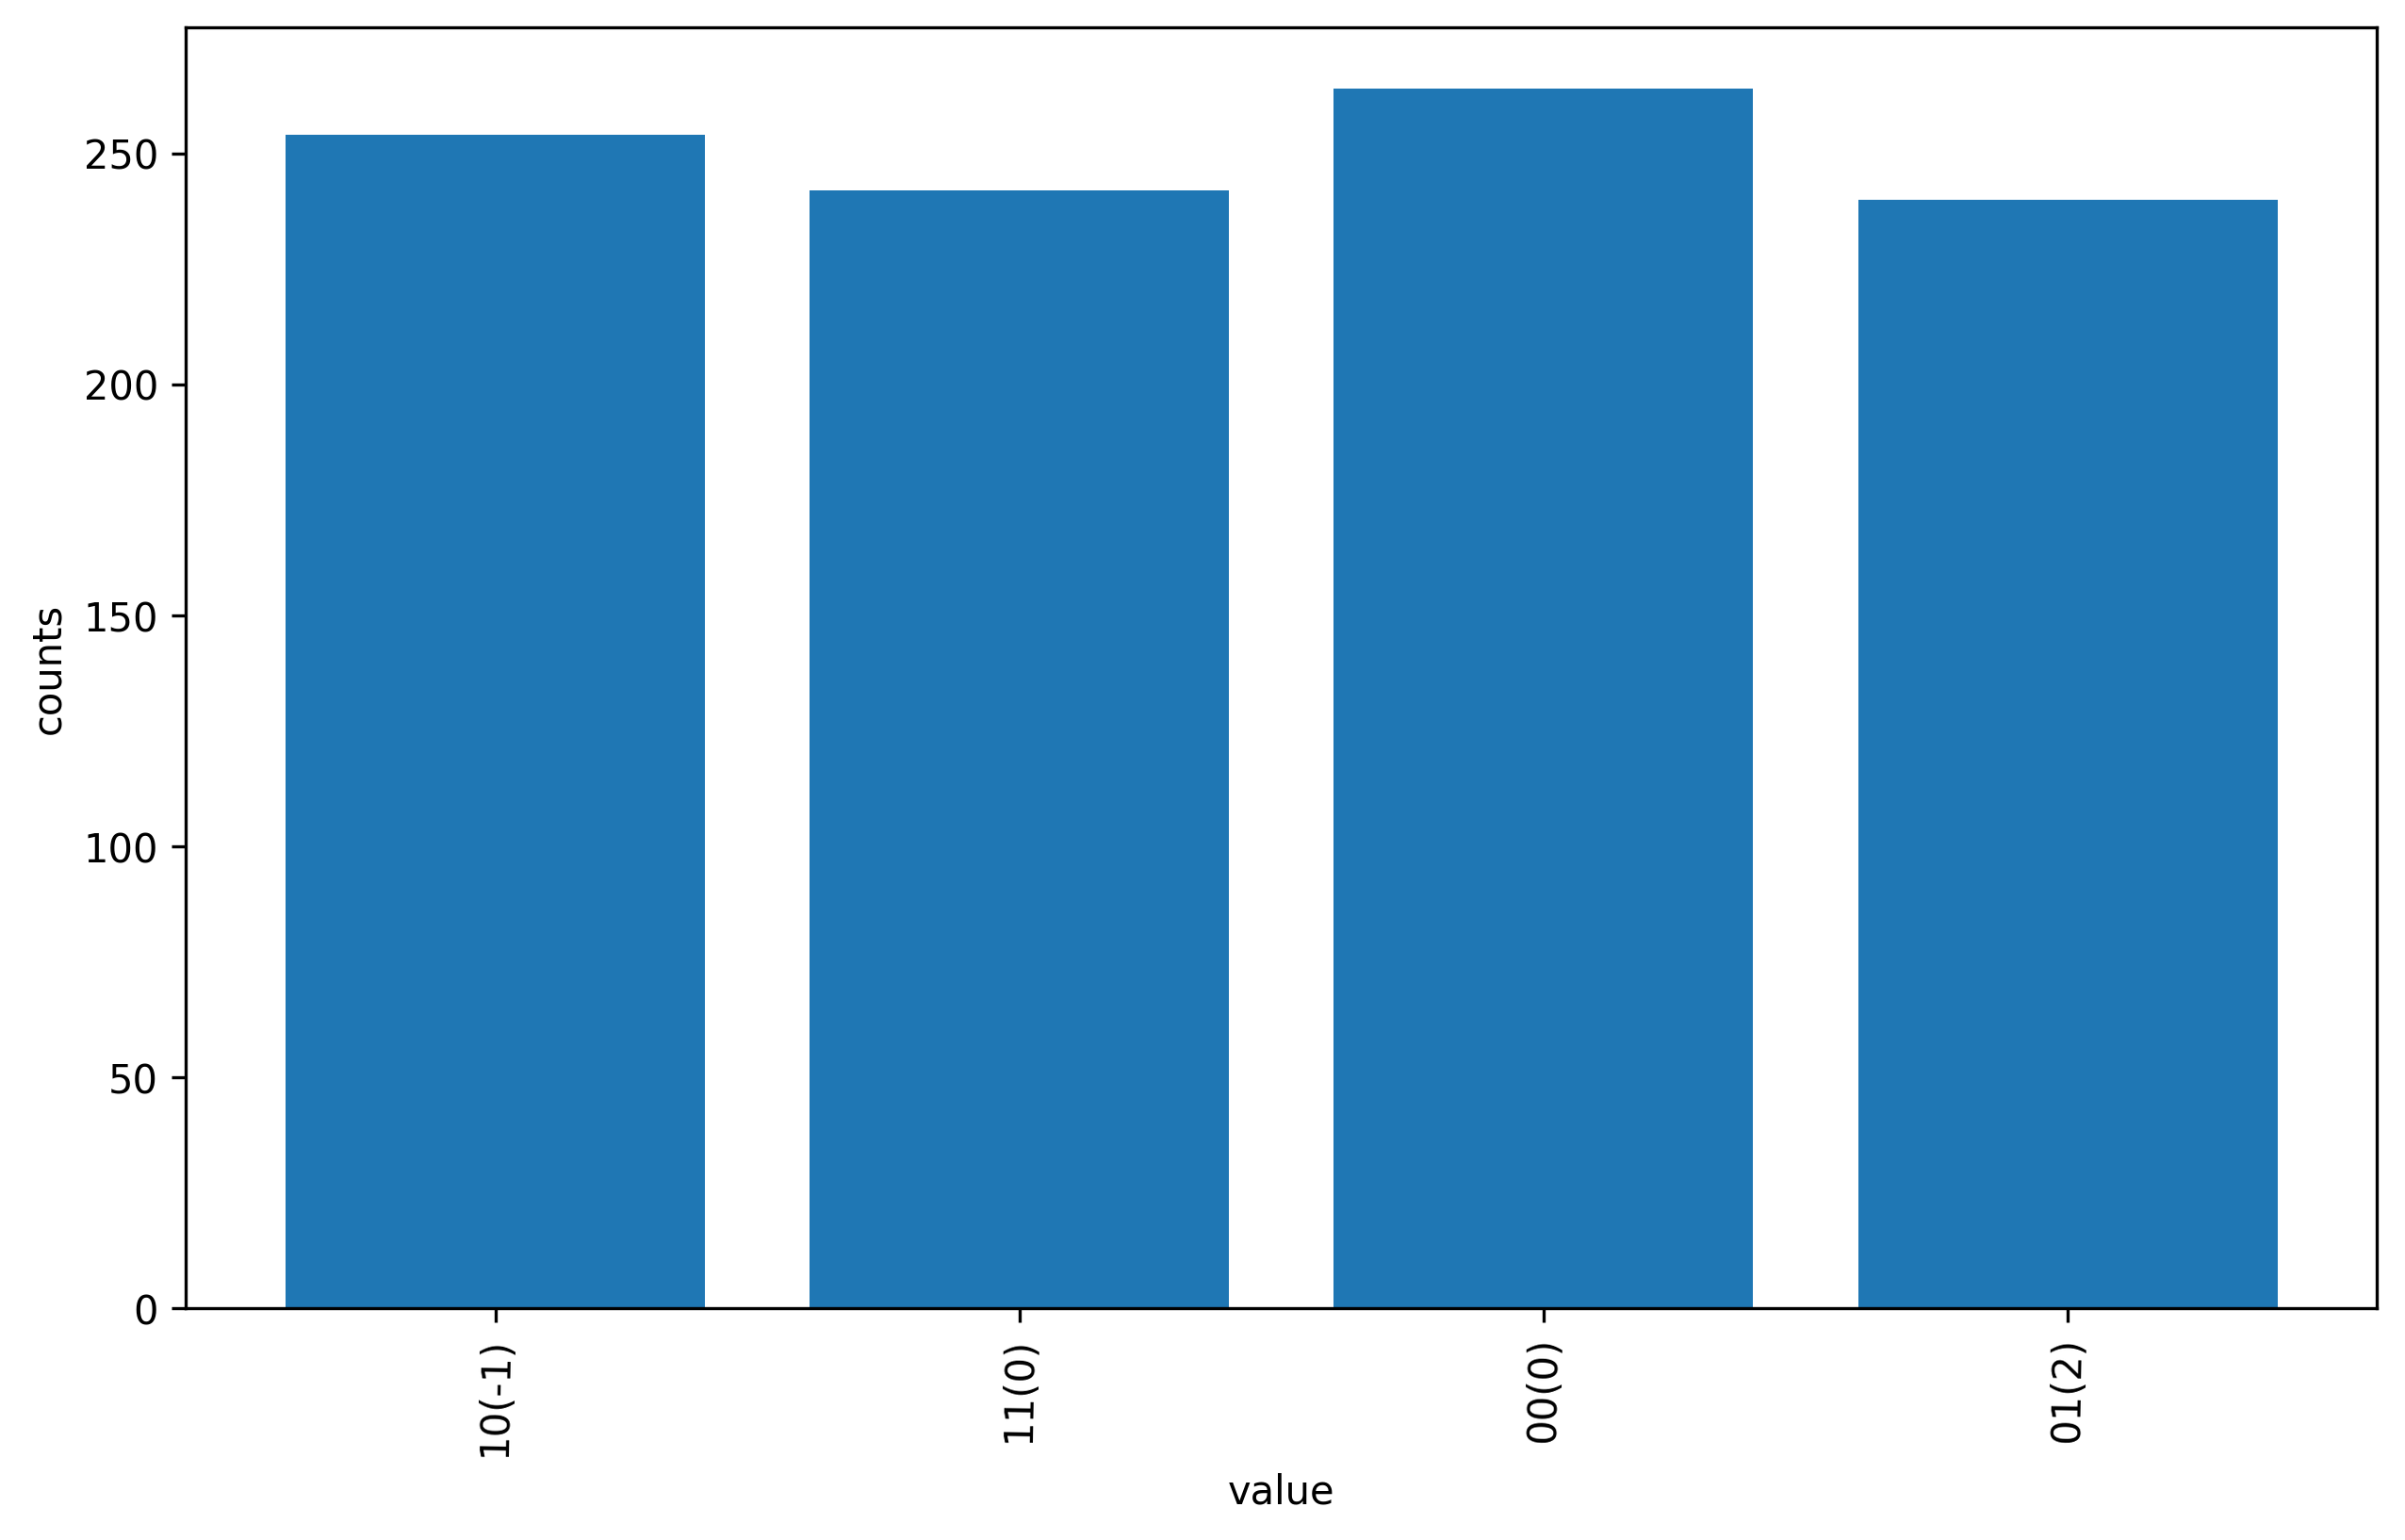

In [28]:
device = LocalSimulator()
result = device.run(qc, shots=1000).result()
counts = result.measurement_counts
print(counts)
# plot using Counter
plot_results_mc(counts,Qubits)

In [26]:
# Another example

[[ 1 -2  1 -1 -3  5]
 [ 0  2 -1 -1  2 -1]
 [ 0  0  3  3 -3 -3]
 [ 0  0  0  1 -2  2]
 [ 0  0  0  0  1  3]
 [ 0  0  0  0  0  2]]
+1x₀²+2x₁²+3x₂²+1x₃²+1x₄²+2x₅²-2x₀x₁+1x₀x₂-1x₀x₃-3x₀x₄+5x₀x₅-1x₁x₂-1x₁x₃+2x₁x₄-1x₁x₅+3x₂x₃-3x₂x₄-3x₂x₅-2x₃x₄+2x₃x₅+3x₄x₅
valid values -31.0 to 31.0
from lowest to highest value
input (cost) count
-----  ----- -----
100110(-3) 141
110110(-2) 171
100010(-1) 145
000110(0) 156
110100(0) 152
000000(0) 155
101010(0) 151
111010(1) 174
000010(1) 158
110000(1) 145
111110(1) 155
000100(1) 156
101110(1) 153
100100(1) 144
001010(1) 159
100000(1) 148
110010(1) 167
010100(2) 136
001001(2) 175
010000(2) 156
011001(2) 144
000001(2) 133
001110(3) 181
010001(3) 159
010110(3) 157
001011(3) 166
001000(3) 163
011010(4) 147
111000(4) 167
011000(4) 157
011110(5) 182
010010(5) 167
010101(5) 188
101000(5) 148
000101(5) 154
011011(5) 136
111100(6) 139
000011(6) 163
001100(7) 149
000111(7) 152
111001(7) 146
101011(7) 156
110001(7) 174
111011(7) 161
011100(7) 145
011101(7) 165
001111(7) 1

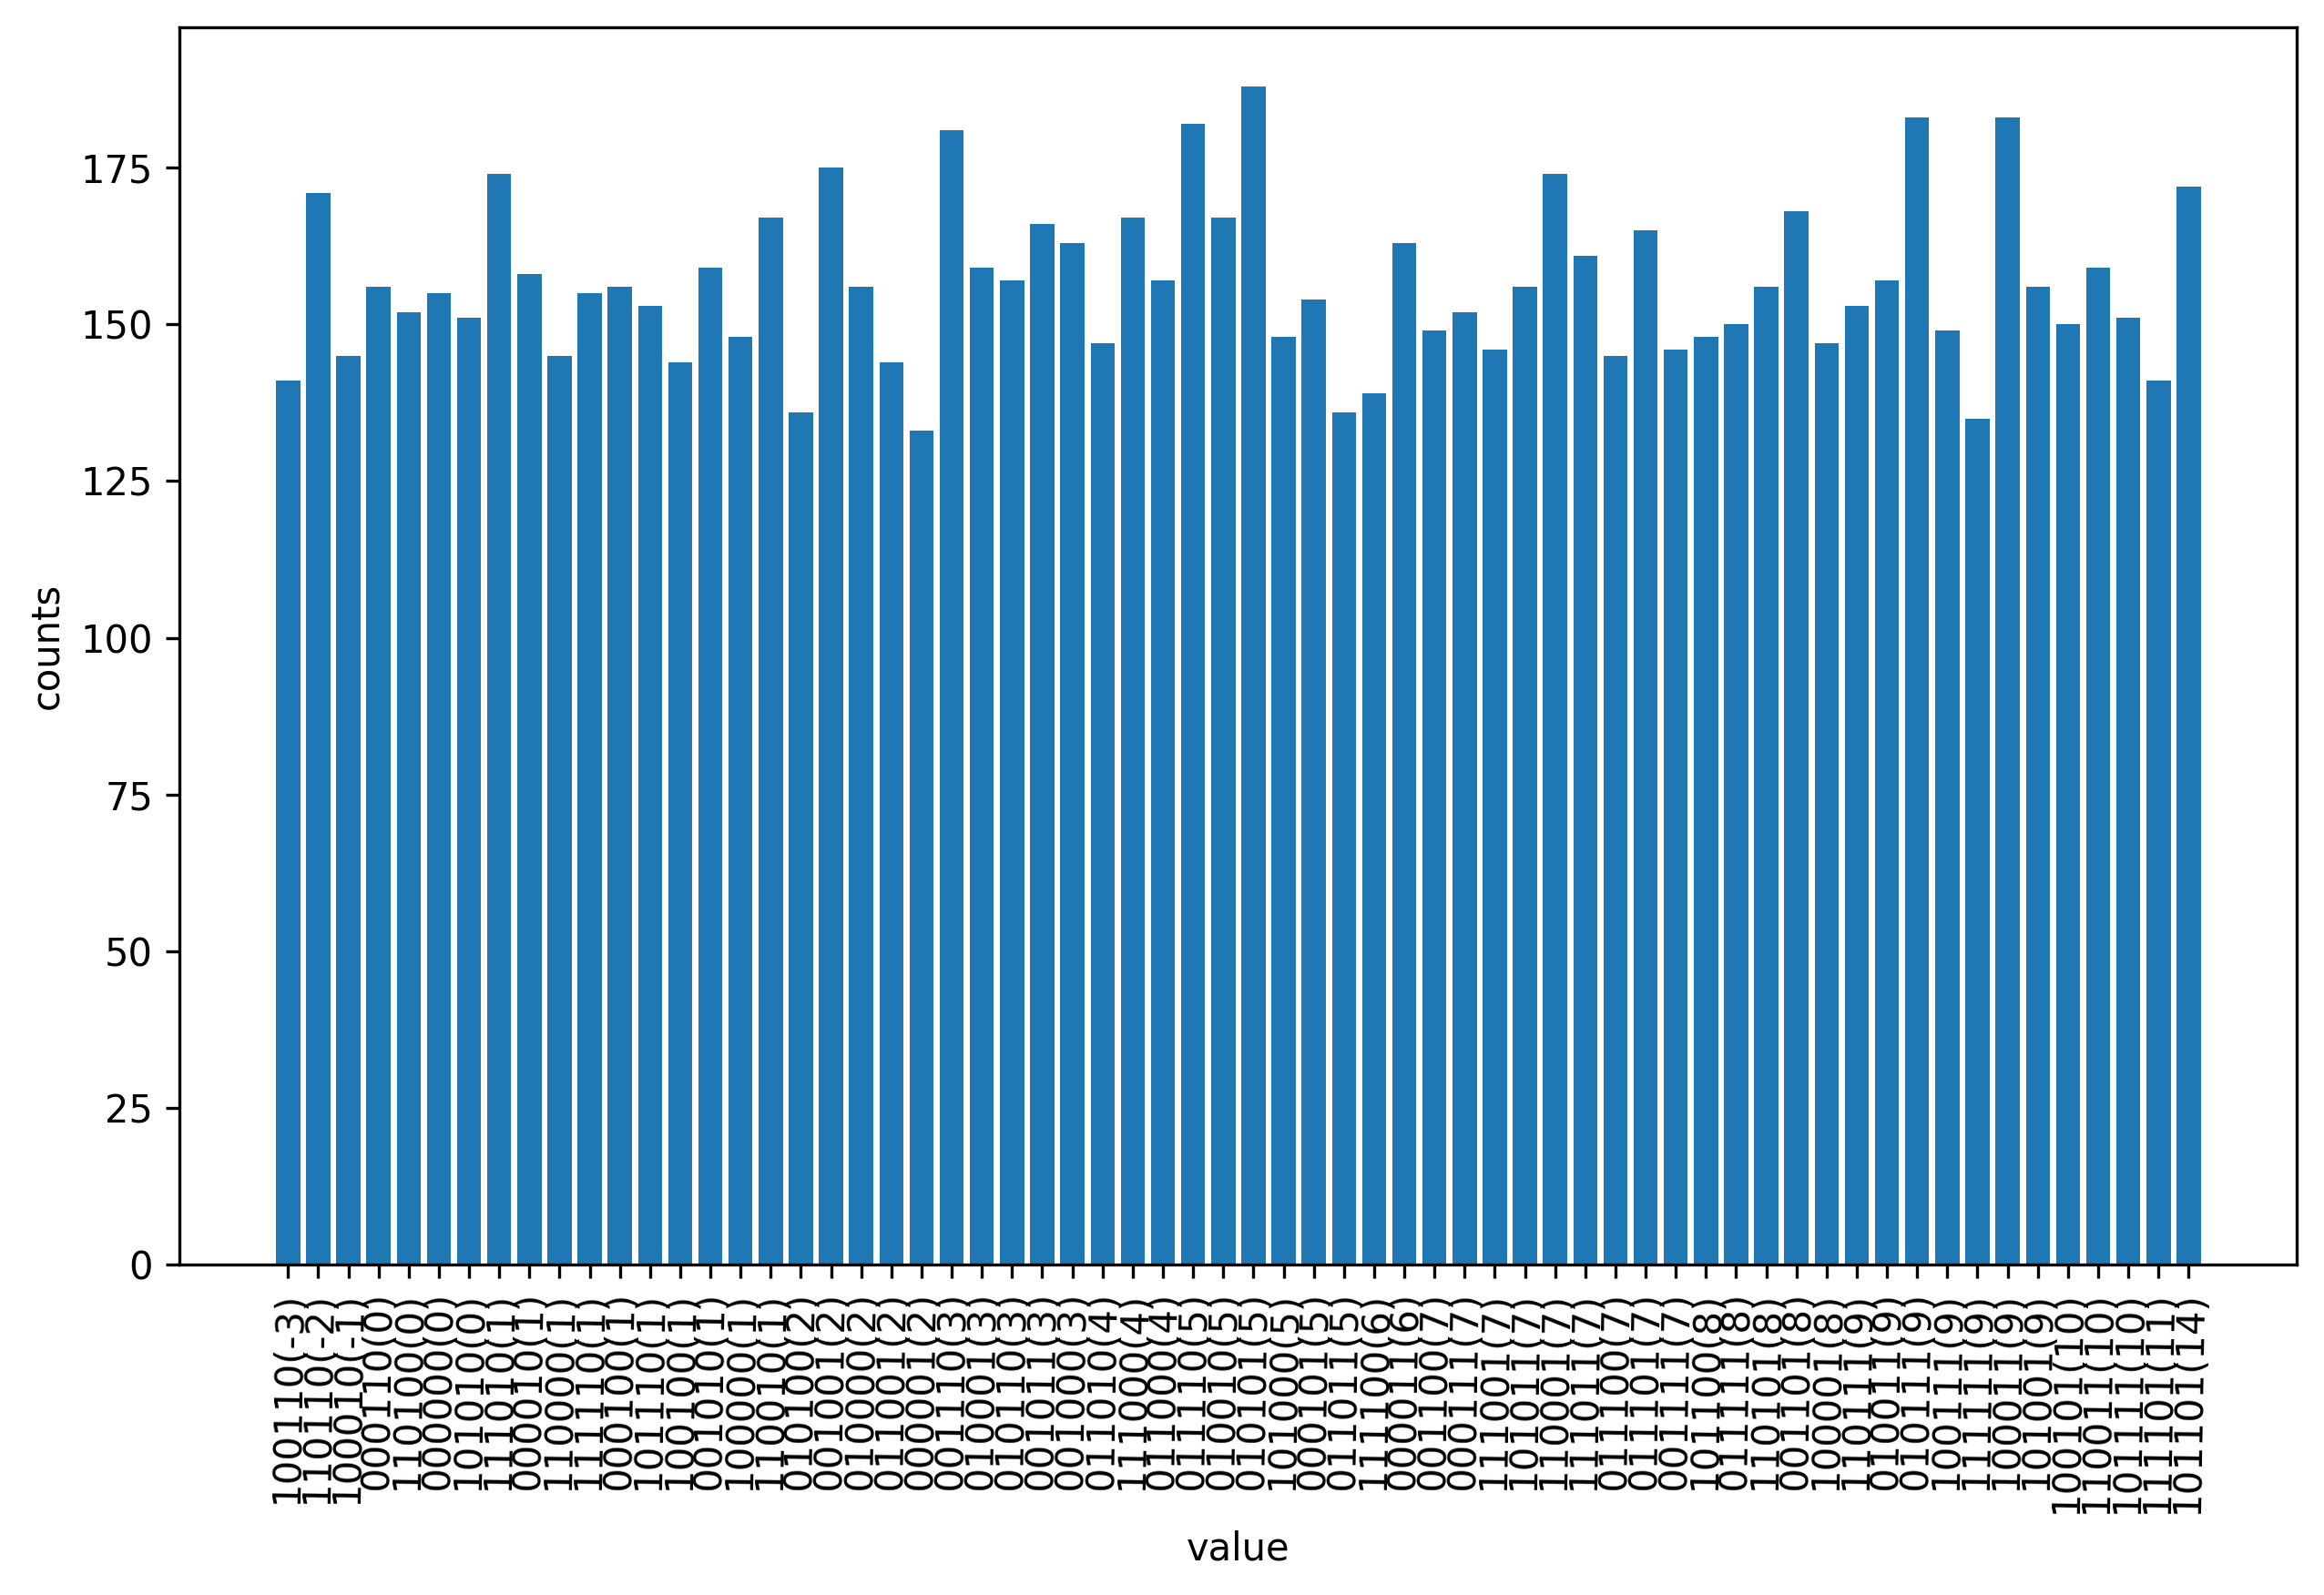

In [31]:
Qubits=6

objective=np.array([[1,-2,1,-1,-3,5],[0,2,-1,-1,2,-1],[0,0,3,3,-3,-3], [0,0,0,1,-2,2],[0,0,0,0,1,3],[0,0,0,0,0,2]])

print(objective)
qc, len_r1, q_start=multi_qubit_polynomial(Qubits, objective)
device = LocalSimulator()
result = device.run(qc, shots=10000).result()
counts = result.measurement_counts
plot_results_mc(counts, Qubits)

In [32]:
print(qc)

T   : |0|     1     |           2           |                 3                  |                       4                        |                  5                  |                        6                         |                  7                  |                   8                   |                  9                   |                 10                  |                  11                  |                  12                  |                   13                   |             14             |                    15                     |                   16                    |                            17                            |                          18                           |                           19                           |                                20                                 |                           21                           |                        22                        |                        23                 